## Demonstrate full circle wide field imaging

This include prediction of components, inversion, point source fitting. We will compare the output images with the input models, looking for closeness in flux and position.

In [1]:
% matplotlib inline

import os
import sys

results_dir = './results'
os.makedirs(results_dir, exist_ok=True)

from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (10.0, 10.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import numpy

from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy import units as u
from astropy.wcs.utils import pixel_to_skycoord

from arl.visibility.base import create_visibility
from arl.visibility.operations import sum_visibility
from arl.visibility.iterators import vis_timeslice_iter
from arl.util.testing_support import create_named_configuration
from arl.util.timing import timing

from matplotlib import pyplot as plt

from arl.skycomponent.operations import create_skycomponent, find_skycomponents, \
    find_nearest_component, insert_skycomponent
from arl.image.operations import show_image, export_image_to_fits, qa_image, smooth_image
from arl.image.iterators import  image_raster_iter
from arl.util.testing_support import create_named_configuration
from arl.imaging import advise_wide_field, predict_2d, predict_wstack, predict_timeslice, predict_facets, \
    predict_wprojection, invert_wstack, invert_2d, invert_timeslice, invert_facets, invert_wprojection, \
    create_image_from_visibility, predict_skycomponent_visibility
from arl.data.polarisation import PolarisationFrame

import logging

log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))

Construct the SKA1-LOW core configuration

In [2]:
lowcore = create_named_configuration('LOWBD2-CORE')

We create the visibility. This just makes the uvw, time, antenna1, antenna2, weight columns in a table

In [3]:
times = numpy.array([-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0]) * (numpy.pi / 12.0)
frequency = numpy.array([1e8])
channel_bandwidth = numpy.array([1e6])
reffrequency = numpy.max(frequency)
phasecentre = SkyCoord(ra=+15.0 * u.deg, dec=-45.0 * u.deg, frame='icrs', equinox='J2000')
vt = create_visibility(lowcore, times, frequency, channel_bandwidth=channel_bandwidth,
                       weight=1.0, phasecentre=phasecentre, 
                       polarisation_frame=PolarisationFrame('stokesI'))

create_visibility: 95865 rows, 0.010 GB


In [4]:
advice = advise_wide_field(vt, wprojection_planes=1)

advise_wide_field: Maximum wavelength 2.998 (meters)


advise_wide_field: Minimum wavelength 2.998 (meters)


advise_wide_field: Maximum baseline 262.6 (wavelengths)


advise_wide_field: Station/antenna diameter 35.0 (meters)


advise_wide_field: Primary beam 0.085655 (rad) 4.908 (deg)


advise_wide_field: Image field of view 0.513930 (rad) 29.446 (deg)


advise_wide_field: Synthesized beam 0.003808 (rad) 0.218 (deg)


advise_wide_field: Cellsize 0.001269 (rad) 0.073 (deg)


advice_wide_field: Npixels per side = 405


advice_wide_field: Npixels (power of 2, 3) per side = 512


advice_wide_field: W sampling for full image = 0.2 (wavelengths)


advice_wide_field: W sampling for primary beam = 8.7 (wavelengths)


advice_wide_field: Time sampling for full image = 25.2 (s)


advice_wide_field: Time sampling for primary beam = 908.6 (s)


advice_wide_field: Frequency sampling for full image = 29212.6 (Hz)


advice_wide_field: Frequency sampling for primary beam = 1051653.8 (Hz)


advice_wide_field: Number of planes in w stack 30


Fill in the visibility with exact calculation of a number of point sources

create_image_from_visibility: Parsing parameters to get definition of WCS


create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 999999.99999 Hz


create_image_from_visibility: uvmax = 262.634709 wavelengths


create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees


create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees


Spacing in pixels = 32


Component at (240.000000, 16.000000) [0-rel] <SkyCoord (ICRS): (ra, dec) in deg
    ( 4.74378292, -51.0209895)>


insert_skycomponent: Using insert method Nearest


Component at (208.000000, 16.000000) [0-rel] <SkyCoord (ICRS): (ra, dec) in deg
    ( 7.66144755, -51.22149637)>


insert_skycomponent: Using insert method Nearest


Component at (176.000000, 16.000000) [0-rel] <SkyCoord (ICRS): (ra, dec) in deg
    ( 10.5917361, -51.35530369)>


insert_skycomponent: Using insert method Nearest


Component at (144.000000, 16.000000) [0-rel] <SkyCoord (ICRS): (ra, dec) in deg
    ( 13.52971731, -51.42224945)>


insert_skycomponent: Using insert method Nearest


Component at (112.000000, 16.000000) [0-rel] <SkyCoord (ICRS): (ra, dec) in deg
    ( 16.47028269, -51.42224945)>


insert_skycomponent: Using insert method Nearest


Component at (80.000000, 16.000000) [0-rel] <SkyCoord (ICRS): (ra, dec) in deg
    ( 19.4082639, -51.35530369)>


insert_skycomponent: Using insert method Nearest


Component at (48.000000, 16.000000) [0-rel] <SkyCoord (ICRS): (ra, dec) in deg
    ( 22.33855245, -51.22149637)>


insert_skycomponent: Using insert method Nearest


Component at (16.000000, 16.000000) [0-rel] <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)>

insert_skycomponent: Using insert method Nearest


Component at (208.000000, 48.000000) [0-rel] <SkyCoord (ICRS): (ra, dec) in deg
    ( 7.94046978, -49.38802398)>


insert_skycomponent: Using insert method Nearest


Component at (176.000000, 48.000000) [0-rel] <SkyCoord (ICRS): (ra, dec) in deg
    ( 10.76004686, -49.51635065)>


insert_skycomponent: Using insert method Nearest


Component at (144.000000, 48.000000) [0-rel] <SkyCoord (ICRS): (ra, dec) in deg
    ( 13.58597172, -49.5805407)>


insert_skycomponent: Using insert method Nearest


Component at (112.000000, 48.000000) [0-rel] <SkyCoord (ICRS): (ra, dec) in deg
    ( 16.41402828, -49.5805407)>


insert_skycomponent: Using insert method Nearest


Component at (80.000000, 48.000000) [0-rel] <SkyCoord (ICRS): (ra, dec) in deg
    ( 19.23995314, -49.51635065)>


insert_skycomponent: Using insert method Nearest


Component at (48.000000, 48.000000) [0-rel] <SkyCoord (ICRS): (ra, dec) in deg
    ( 22.05953022, -49.38802398)>


insert_skycomponent: Using insert method Nearest


Component at (16.000000, 48.000000) [0-rel] <SkyCoord (ICRS): (ra, dec) in deg
    ( 24.86868384, -49.19566221)>


insert_skycomponent: Using insert method Nearest


Component at (176.000000, 80.000000) [0-rel] <SkyCoord (ICRS): (ra, dec) in deg
    ( 10.91156133, -47.68176393)>


insert_skycomponent: Using insert method Nearest


Component at (144.000000, 80.000000) [0-rel] <SkyCoord (ICRS): (ra, dec) in deg
    ( 13.63659973, -47.74353279)>


insert_skycomponent: Using insert method Nearest


Component at (112.000000, 80.000000) [0-rel] <SkyCoord (ICRS): (ra, dec) in deg
    ( 16.36340027, -47.74353279)>

insert_skycomponent: Using insert method Nearest


Component at (80.000000, 80.000000) [0-rel] <SkyCoord (ICRS): (ra, dec) in deg
    ( 19.08843867, -47.68176393)>


insert_skycomponent: Using insert method Nearest


Component at (48.000000, 80.000000) [0-rel] <SkyCoord (ICRS): (ra, dec) in deg
    ( 21.80822877, -47.55825467)>


insert_skycomponent: Using insert method Nearest


Component at (16.000000, 80.000000) [0-rel] <SkyCoord (ICRS): (ra, dec) in deg
    ( 24.51939763, -47.3730574)>


insert_skycomponent: Using insert method Nearest


Component at (144.000000, 112.000000) [0-rel] <SkyCoord (ICRS): (ra, dec) in deg
    ( 13.68235336, -45.90931658)>


insert_skycomponent: Using insert method Nearest


Component at (112.000000, 112.000000) [0-rel] <SkyCoord (ICRS): (ra, dec) in deg
    ( 16.31764664, -45.90931658)>


insert_skycomponent: Using insert method Nearest


Component at (80.000000, 112.000000) [0-rel] <SkyCoord (ICRS): (ra, dec) in deg
    ( 18.95148298, -45.84967813)>


insert_skycomponent: Using insert method Nearest


Component at (48.000000, 112.000000) [0-rel] <SkyCoord (ICRS): (ra, dec) in deg
    ( 21.58097973, -45.73040913)>


insert_skycomponent: Using insert method Nearest


Component at (16.000000, 112.000000) [0-rel] <SkyCoord (ICRS): (ra, dec) in deg
    ( 24.20334715, -45.55152143)>


insert_skycomponent: Using insert method Nearest


Component at (112.000000, 144.000000) [0-rel] <SkyCoord (ICRS): (ra, dec) in deg
    ( 16.27614945, -44.07600819)>


insert_skycomponent: Using insert method Nearest


Component at (80.000000, 144.000000) [0-rel] <SkyCoord (ICRS): (ra, dec) in deg
    ( 18.82724608, -44.01824481)>


insert_skycomponent: Using insert method Nearest


Component at (48.000000, 144.000000) [0-rel] <SkyCoord (ICRS): (ra, dec) in deg
    ( 21.37476195, -43.90270873)>


insert_skycomponent: Using insert method Nearest


Component at (16.000000, 144.000000) [0-rel] <SkyCoord (ICRS): (ra, dec) in deg
    ( 23.91639614, -43.72937783)>


insert_skycomponent: Using insert method Nearest


Component at (80.000000, 176.000000) [0-rel] <SkyCoord (ICRS): (ra, dec) in deg
    ( 18.71420256, -42.18561677)>


insert_skycomponent: Using insert method Nearest


Component at (48.000000, 176.000000) [0-rel] <SkyCoord (ICRS): (ra, dec) in deg
    ( 21.18706763, -42.07336315)>


insert_skycomponent: Using insert method Nearest


Component at (16.000000, 176.000000) [0-rel] <SkyCoord (ICRS): (ra, dec) in deg
    ( 23.65510465, -41.90491964)>


insert_skycomponent: Using insert method Nearest


Component at (48.000000, 208.000000) [0-rel] <SkyCoord (ICRS): (ra, dec) in deg
    ( 21.01580068, -40.24055692)>


insert_skycomponent: Using insert method Nearest


Component at (16.000000, 208.000000) [0-rel] <SkyCoord (ICRS): (ra, dec) in deg
    ( 23.41659285, -40.07639948)>


insert_skycomponent: Using insert method Nearest


Component at (16.000000, 240.000000) [0-rel] <SkyCoord (ICRS): (ra, dec) in deg
    ( 23.19843619, -38.24201755)>


insert_skycomponent: Using insert method Nearest


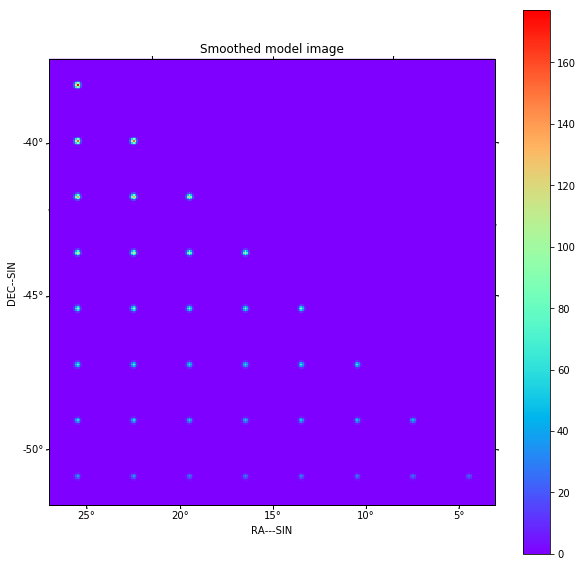

In [9]:
vt.data['vis'] *= 0.0
npixel=256

model = create_image_from_visibility(vt, npixel=npixel, cellsize=0.001, nchan=1, 
                                     polarisation_frame=PolarisationFrame('stokesI'))
centre = model.wcs.wcs.crpix-1
spacing_pixels = npixel // 8
log.info('Spacing in pixels = %s' % spacing_pixels)
spacing = model.wcs.wcs.cdelt * spacing_pixels
locations = [-3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5]

original_comps = []
# We calculate the source positions in pixels and then calculate the
# world coordinates to put in the skycomponent description
for iy in locations:
    for ix in locations:
        if ix >= iy:
            p = int(round(centre[0] + ix * spacing_pixels * numpy.sign(model.wcs.wcs.cdelt[0]))), \
                int(round(centre[1] + iy * spacing_pixels * numpy.sign(model.wcs.wcs.cdelt[1])))
            sc = pixel_to_skycoord(p[0], p[1], model.wcs)
            log.info("Component at (%f, %f) [0-rel] %s" % (p[0], p[1], str(sc)))
            flux = numpy.array([[100.0 + 2.0 * ix + iy * 20.0]])
            comp = create_skycomponent(flux=flux, frequency=frequency, direction=sc, 
                                       polarisation_frame=PolarisationFrame('stokesI'))
            original_comps.append(comp)
            insert_skycomponent(model, comp)

predict_skycomponent_visibility(vt, original_comps)

        
cmodel = smooth_image(model) 
show_image(cmodel)
plt.title("Smoothed model image")
plt.show()

Check that the skycoordinate and image coordinate system are consistent by finding the point sources.

find_skycomponents: Finding components in Image by segmentation


find_skycomponents: Identified 36 segments


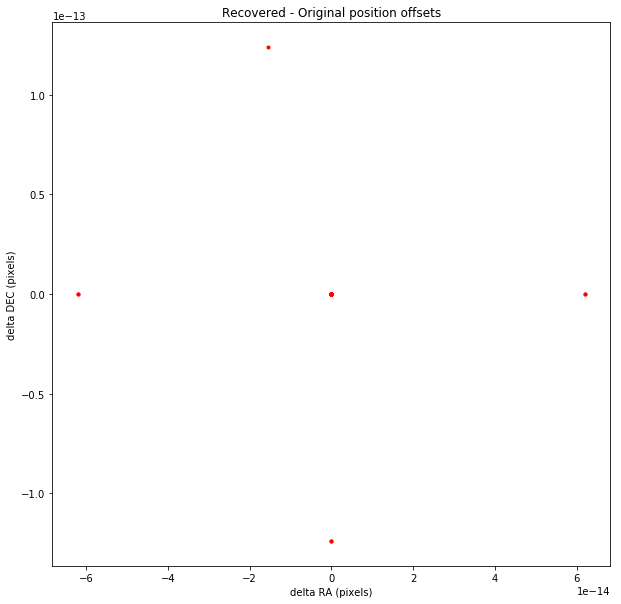

In [9]:
comps = find_skycomponents(cmodel, fwhm=1.0, threshold=10.0, npixels=5)
plt.clf()
for i in range(len(comps)):
    ocomp = find_nearest_component(comps[i].direction, original_comps)
    plt.plot((comps[i].direction.ra.value  - ocomp.direction.ra.value)/cmodel.wcs.wcs.cdelt[0], 
             (comps[i].direction.dec.value - ocomp.direction.dec.value)/cmodel.wcs.wcs.cdelt[1], 
             '.', color='r')  

plt.xlabel('delta RA (pixels)')
plt.ylabel('delta DEC (pixels)')
plt.title("Recovered - Original position offsets")
plt.show()

Predict the visibility using the different approaches.

In [14]:
from arl.imaging.imaging_context import imaging_contexts, predict_context
contexts = imaging_contexts().keys()
print(contexts)

dict_keys(['2d', 'slice', 'facets+slice', 'timeslice', 'facets+timeslice', 'facets', 'wstack', 'facets+wstack'])


create_visibility: 95865 rows, 0.010 GB


predict_with_iterators: Processing chunks


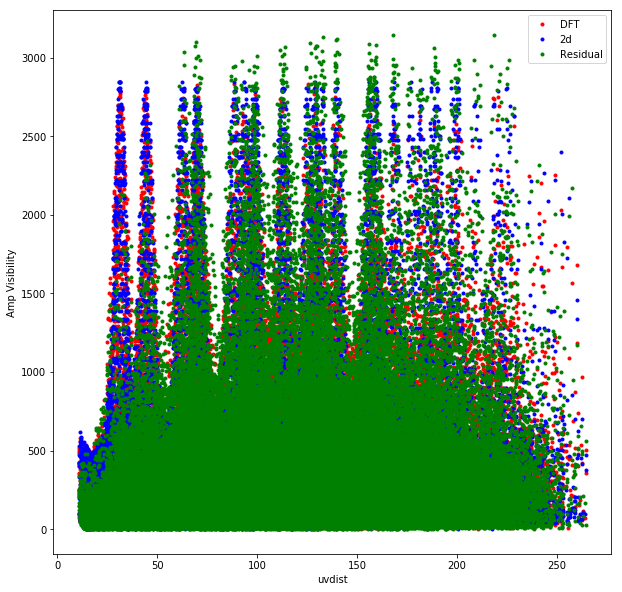

create_visibility: 95865 rows, 0.010 GB


predict_with_iterators: Processing chunks


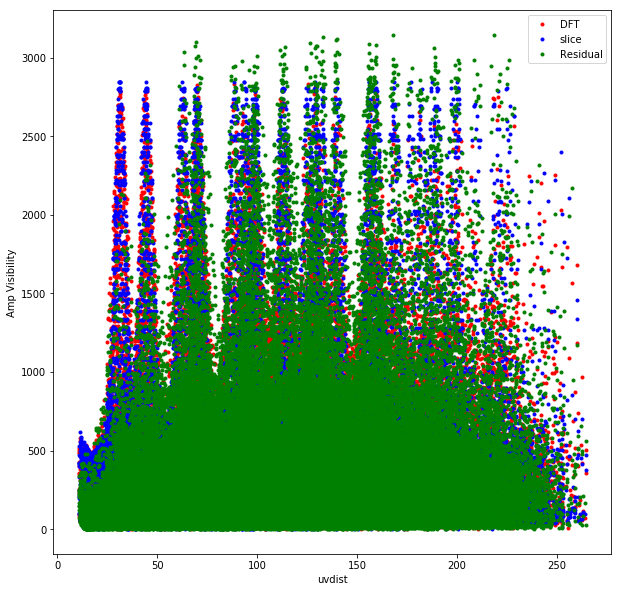

create_visibility: 95865 rows, 0.010 GB


predict_with_iterators: Processing chunks


raster: predicting using 8 x 8 image partitions


raster: spacing of raster (32, 32)


raster: partition (0, 0) of (8, 8)


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>

shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>


In [15]:
from arl.imaging.imaging_context import imaging_contexts, predict_context
contexts = imaging_contexts().keys()

for context in contexts:
    
    print('Processing context %s' % context)
    if context == 'slice' or context == 'facets+slice':
        vis_slices=10000
    else:
        vis_slices=31
    
    uvdist=numpy.sqrt(vt.data['uvw'][:,0]**2+vt.data['uvw'][:,1]**2)
    plt.clf()
    plt.plot(uvdist, numpy.abs(vt.data['vis'][:]), '.', color='r', label="DFT")   
    vtpredict = create_visibility(lowcore, times, frequency, channel_bandwidth=channel_bandwidth,
                                  weight=1.0, phasecentre=phasecentre,
                                 polarisation_frame=PolarisationFrame('stokesI'))
    vtpredict = predict_context(vtpredict, model, context=context, timeslice='auto', vis_slices=vis_slices,
                         oversampling=4, facets=8, wstep=advice['w_sampling_primary_beam'])
        
    plt.plot(uvdist, numpy.abs(vtpredict.data['vis'][:]), '.', color='b', label=context)
    plt.plot(uvdist, numpy.abs(vtpredict.data['vis'][:]-vt.data['vis'][:]), '.', color='g', label="Residual")
    plt.xlabel('uvdist')
    plt.ylabel('Amp Visibility')
    plt.legend()
    plt.show()

Make the image using the different approaches. We will evaluate the results using a number of plots:

- The error in fitted versus the radius. The ideal result is a straightline fitted: flux = DFT flux
- The offset in RA versus the offset in DEC. The ideal result is a cluster around 0 pixels.

The sampling in w is set to provide 2% decorrelation at the half power point of the primary beam.


create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 999999.99999 Hz
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
invert_wstack: inverting using wstack
invert_wstack_single: predicting using single w slice
invert_2d_base: retaining imaginary part of dirty image
create_w_term_image: For w = -158.7, field of view = 0.256000, Fresnel number = 2.60
invert_wstack_single: predicting using single w slice
invert_2d_base: retaining imaginary part of dirty image
create_w_term_image: For w = -151.5, field of view = 0.256000, Fresnel number = 2.48
invert_wstack_single: predicting using single w slice
invert_2d_base: retaining imagi

create_w_term_image: For w = 167.9, field of view = 0.256000, Fresnel number = 2.75
func:'makeimage' took: 4.3935 sec


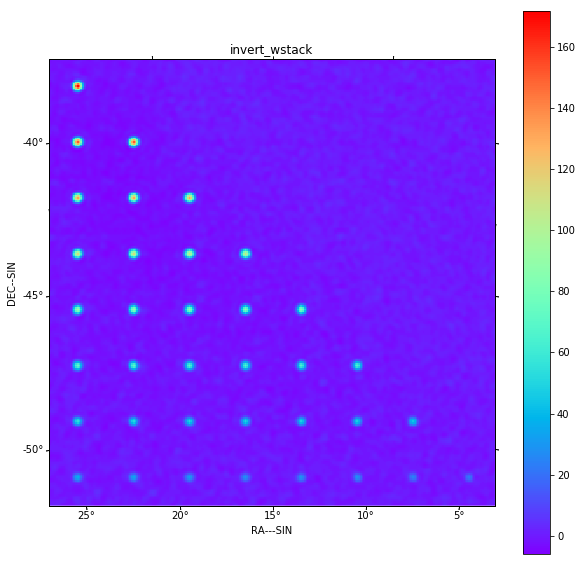

Dirty Image Quality assessment:
	Origin: qa_image
	Context: imaging-fits notebook, using processor invert_wstack
	Data:
		shape: (1, 1, 256, 256)
		max: 171.783971238
		min: -6.02930689365
		rms: 6.51116550304
		sum: 3181.88789381
		medianabs: 1.13649868429
		median: -0.656150096397

find_skycomponents: Finding components in Image by segmentation
find_skycomponents: Identified 36 segments


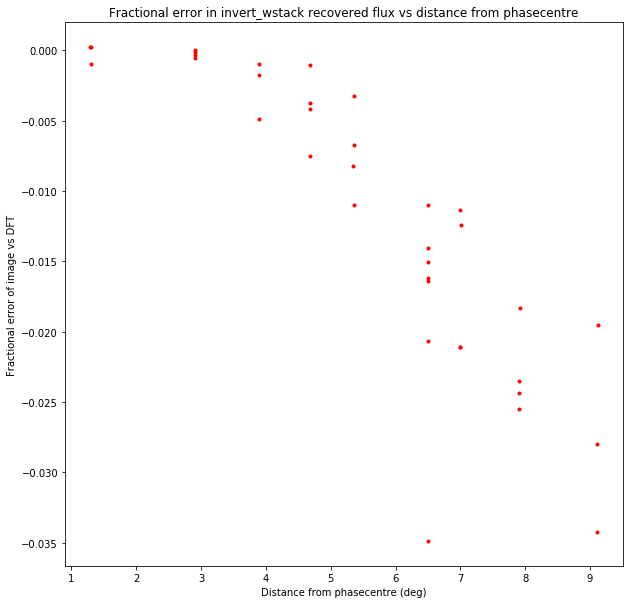

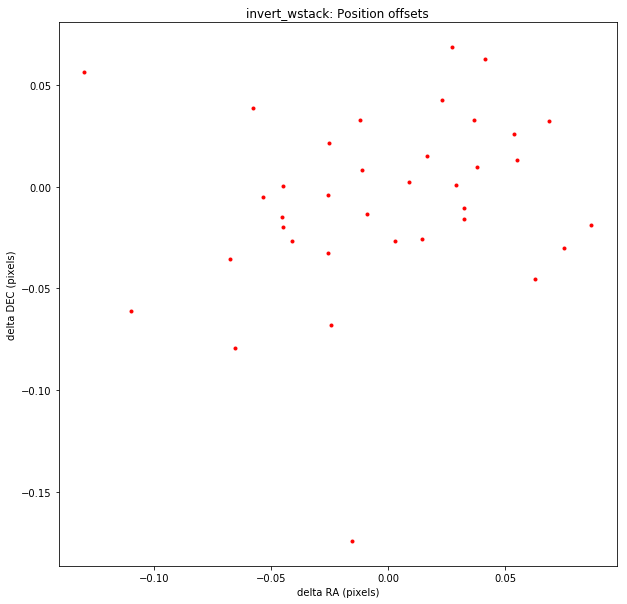

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 999999.99999 Hz
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
invert_2d: inverting using 2d transform
func:'makeimage' took: 0.8142 sec


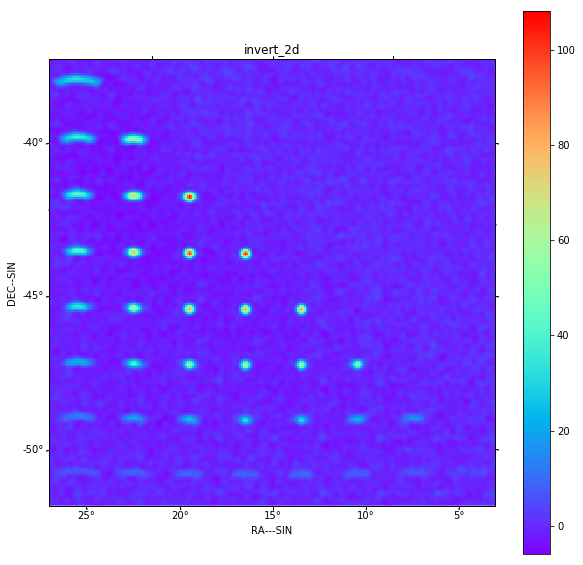

Dirty Image Quality assessment:
	Origin: qa_image
	Context: imaging-fits notebook, using processor invert_2d
	Data:
		shape: (1, 1, 256, 256)
		max: 108.253278278
		min: -6.00700715117
		rms: 4.91806858509
		sum: 3407.06614468
		medianabs: 1.15494489329
		median: -0.583566724556

find_skycomponents: Finding components in Image by segmentation
find_skycomponents: Identified 28 segments


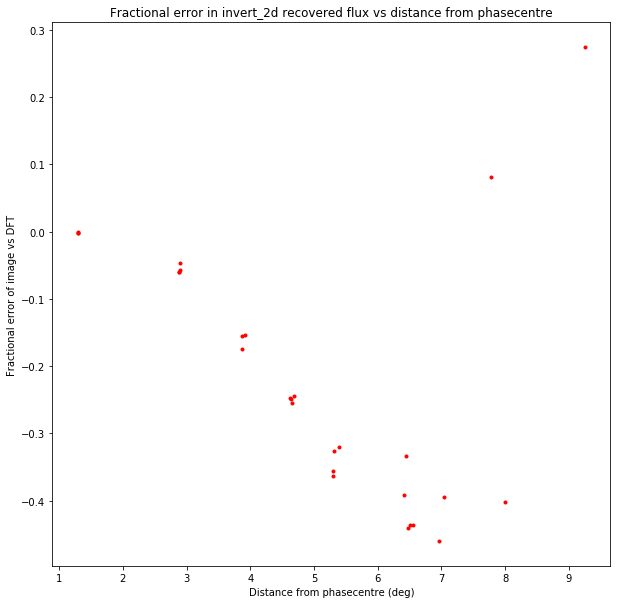

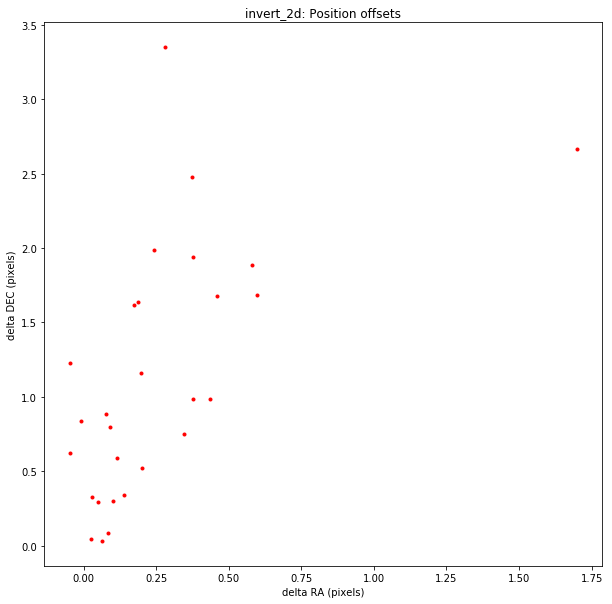

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 999999.99999 Hz
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
invert_timeslice: inverting using time slices
invert_timeslice_single: inverting using single time slice
fit_uvwplane: Fit to 13695 rows reduces rms w from 59.6 to 0.0 m
invert_timeslice_single: inverting using single time slice
fit_uvwplane: Fit to 13695 rows reduces rms w from 46.1 to 0.0 m
invert_timeslice_single: inverting using single time slice
fit_uvwplane: Fit to 13695 rows reduces rms w from 33.7 to 0.0 m
invert_timeslice_single: inverting using single time slice
fit_uvwplane: Fit to 13695 rows redu

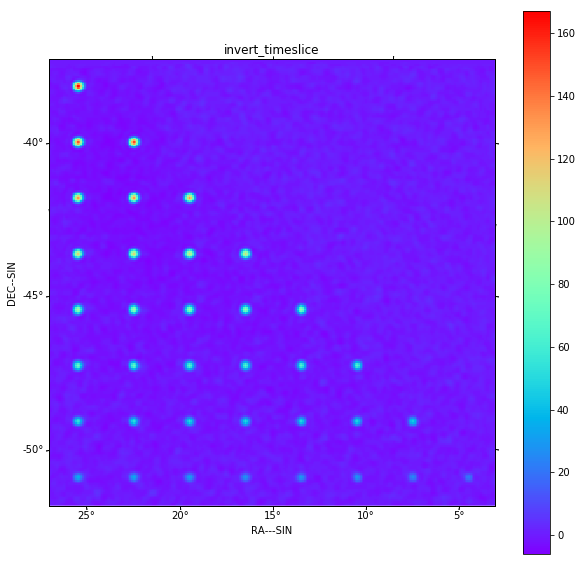

Dirty Image Quality assessment:
	Origin: qa_image
	Context: imaging-fits notebook, using processor invert_timeslice
	Data:
		shape: (1, 1, 256, 256)
		max: 167.149609551
		min: -6.08297219447
		rms: 6.50141297337
		sum: 4187.44912462
		medianabs: 1.10429430487
		median: -0.627610396883

find_skycomponents: Finding components in Image by segmentation
find_skycomponents: Identified 36 segments


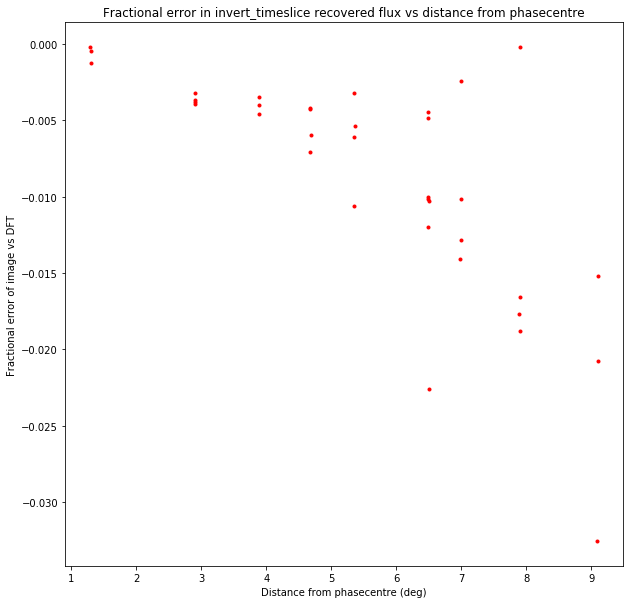

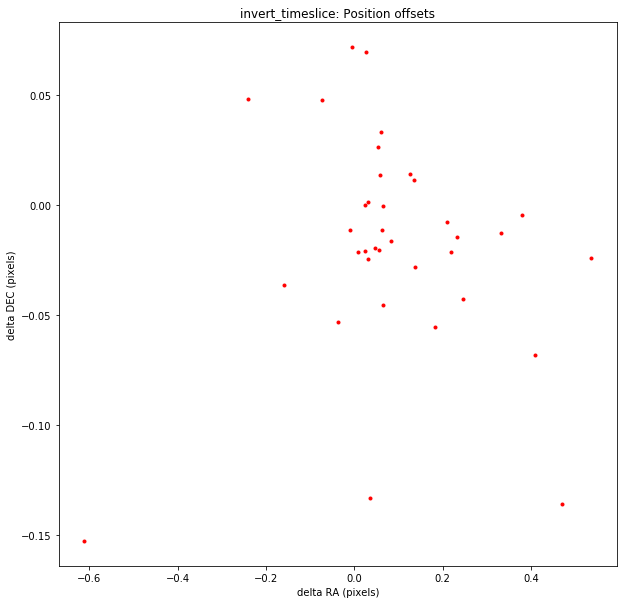

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 999999.99999 Hz
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
invert_facets: Inverting by image facets
invert_with_image_iterator: Inverting by image partitions
raster: predicting using 4 x 4 image partitions
raster: spacing of raster (64, 64)
raster: partition (0, 0) of (4, 4)
shift_vis_from_image: shifting phasecentre from vis phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)> to image phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 23.62802131, -50.21418966)>
raster: partition (1, 0) of (4, 4)
shift_vis_from_image: shifting phasecentre from vis ph

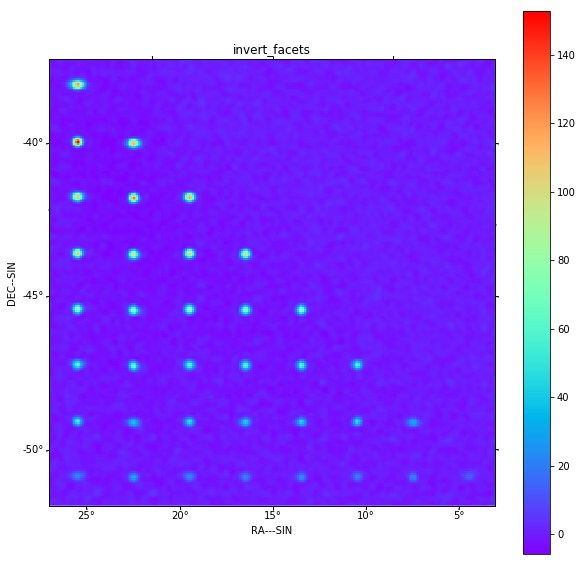

Dirty Image Quality assessment:
	Origin: qa_image
	Context: imaging-fits notebook, using processor invert_facets
	Data:
		shape: (1, 1, 256, 256)
		max: 152.856023432
		min: -5.85390601572
		rms: 6.16986140778
		sum: 3665.57448699
		medianabs: 1.13715738142
		median: -0.634398411738

find_skycomponents: Finding components in Image by segmentation
find_skycomponents: Identified 36 segments


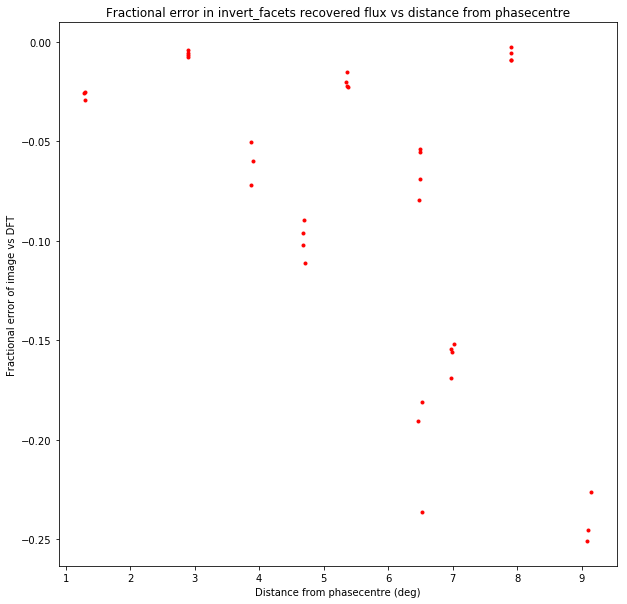

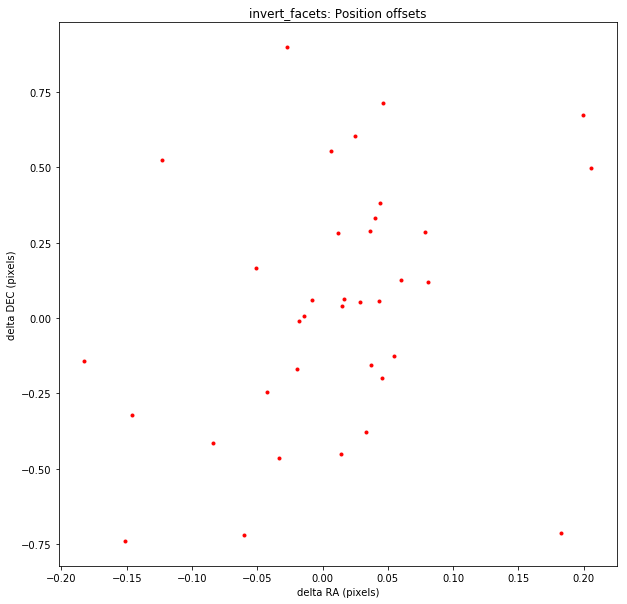

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 999999.99999 Hz
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
invert_2d: inverting using wprojection
get_kernel_list: Using wprojection kernel
get_kernel_list: Fresnel number = 16.384000
advise_wide_field: Maximum wavelength 2.998 (meters)
advise_wide_field: Minimum wavelength 2.998 (meters)
advise_wide_field: Maximum baseline 262.6 (wavelengths)
advise_wide_field: Station/antenna diameter 35.0 (meters)
advise_wide_field: Primary beam 0.085655 (rad) 4.908 (deg)
advise_wide_field: Image field of view 0.513930 (rad) 29.446 (deg)
advise_wide_field: Synthesized beam 0.0038

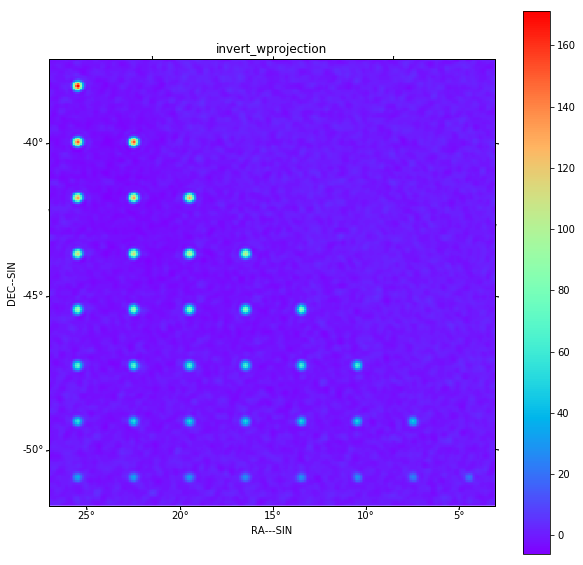

Dirty Image Quality assessment:
	Origin: qa_image
	Context: imaging-fits notebook, using processor invert_wprojection
	Data:
		shape: (1, 1, 256, 256)
		max: 171.341611218
		min: -6.18768112093
		rms: 6.50858709498
		sum: 3223.91152521
		medianabs: 1.1354702951
		median: -0.653936702621

find_skycomponents: Finding components in Image by segmentation
find_skycomponents: Identified 36 segments


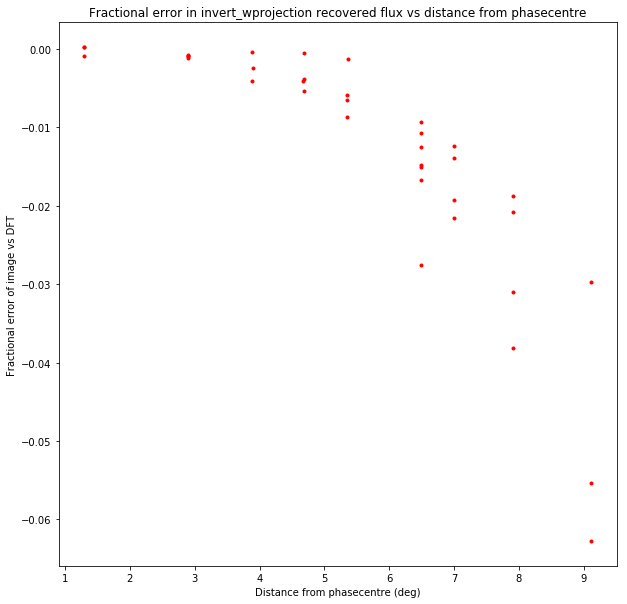

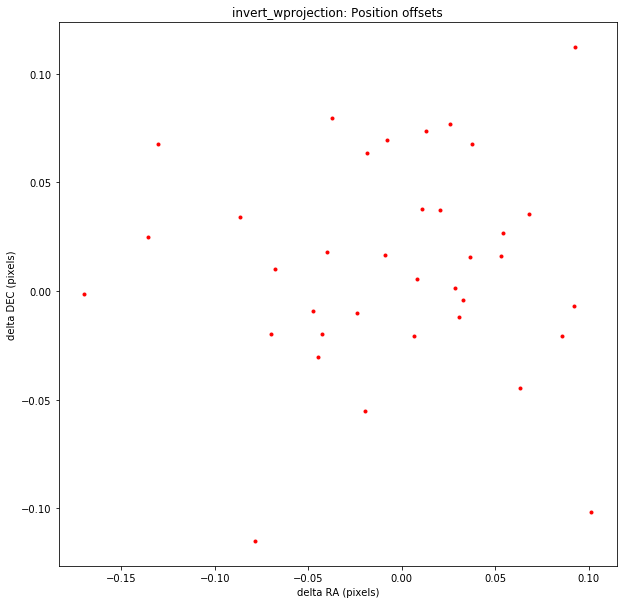

In [8]:
processors = [invert_wstack, invert_2d, invert_timeslice, invert_facets, invert_wprojection]

for processor in processors:

    targetimage = create_image_from_visibility(vt, npixel=npixel, cellsize=0.001, nchan=1,
                                              polarisation_frame=PolarisationFrame('stokesI'))
    @timing
    def makeimage():
        return processor(vt, targetimage, timeslice='auto', padding=2, oversampling=4,
                         facets=4, wstack=advice['w_sampling_primary_beam'], vis_slices=31,
                         wstep=advice['w_sampling_primary_beam'])
        
    targetimage, sumwt = makeimage()

    
    show_image(targetimage)
    plt.title(processor.__name__)
    plt.show()
    
    print("Dirty Image %s" % 
          qa_image(targetimage, context="imaging-fits notebook, using processor %s" %(processor.__name__)))
    
    export_image_to_fits(targetimage, '%s/imaging-fits_dirty_%s.fits' %(results_dir, processor.__name__))
    comps = find_skycomponents(targetimage, fwhm=1.0, threshold=10.0, npixels=5)

    plt.clf()
    for comp in comps:
        distance = comp.direction.separation(model.phasecentre)
        dft_flux = sum_visibility(vt, comp.direction)[0] 
        err = (comp.flux[0,0] - dft_flux ) / dft_flux
        plt.plot(distance, err, '.', color='r')
    plt.ylabel('Fractional error of image vs DFT')
    plt.xlabel('Distance from phasecentre (deg)')
    plt.title("Fractional error in %s recovered flux vs distance from phasecentre" % (processor.__name__))
    plt.show()

    checkpositions = True
    if checkpositions:
        plt.clf()
        for i in range(len(comps)):
            ocomp = find_nearest_component(comps[i].direction, original_comps)
            plt.plot((comps[i].direction.ra.value  - ocomp.direction.ra.value)/targetimage.wcs.wcs.cdelt[0], 
                     (comps[i].direction.dec.value - ocomp.direction.dec.value)/targetimage.wcs.wcs.cdelt[1], 
                     '.', color='r')  

        plt.xlabel('delta RA (pixels)')
        plt.ylabel('delta DEC (pixels)')
        plt.title("%s: Position offsets" % (processor.__name__))
        plt.show()